In [6]:
import pandas as pd
import numpy as np

In [7]:
data = pd.read_csv("Data4Modelling.csv")

In [8]:
data = data.replace([np.inf, -np.inf], 0)

In [9]:
non_numeric_columns = data.select_dtypes(exclude=[float, int])
data["weight"]  = ["UNK" if str(i) == str(np.nan) else i for i in data["weight"] ]
data.weight.value_counts()

weight
UNK          96958
[75-100)      1320
[50-75)        881
[100-125)      622
[125-150)      143
[25-50)         94
[0-25)          48
[150-175)       34
[175-200)       11
>200             3
Name: count, dtype: int64

In [10]:
weightDict = {'[50-75)' : '62',
'[75-100)' : '87',
'[100-125)' : '112', 
'[125-150)' : '137', 
'[25-50)' : '37', 
'[0-25)' : '12',
'[150-175)' : '162', 
'[175-200)' : '187',
'>200' : '200',
'UNK' : f"{np.nan}"}

data['weight'] = data['weight'].apply(lambda x : weightDict[x])

In [11]:
data.weight = data.weight.astype(float)

In [12]:
data_checkout = data.copy()

In [13]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

In [14]:
for column in data.columns:
    if data[column].dtype == 'object':
        data[column] = label_encoder.fit_transform(data[column])

C:\Users\user\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\user\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\user\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\user\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_d

In [15]:
data['readmitted'].value_counts()

readmitted
0    88757
1    11357
Name: count, dtype: int64

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
import time
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier, ExtraTreesClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from tabulate import tabulate
from tqdm import tqdm

In [17]:
def BasedLine(df, method, models, n_splits=10):
    start_time = time.time()  # Record the start time

    df_check = df.copy()
    
    df_check.weight = df_check.weight.fillna(method)
    
    y = df_check['readmitted']
    X = df_check.drop(columns='readmitted')

    # Define the cross-validation strategy (Stratified K-Fold)
    stratified_kfold = StratifiedKFold(n_splits=n_splits, random_state=2023, shuffle=True)

    # Test options and evaluation metric
    scoring = 'accuracy'
    results, results_weigh = [], []
    names = []
    scores, scores_weigh = [], []
    data = []
    for name, model in models:
        # Initialize lists to store individual model scores
        model_scores = []
        model_scores_weigh = []
        
        with tqdm(total=n_splits, desc=f"Running {name}") as pbar:
            for train_idx, test_idx in stratified_kfold.split(X, y):
                X_train, X_valid = X.iloc[train_idx], X.iloc[test_idx]
                y_train, y_valid = y.iloc[train_idx], y.iloc[test_idx]
                
                model.fit(X_train, y_train)
                score_non = f1_score(model.predict(X_valid), y_valid)
                score_weigh = f1_score(model.predict(X_valid), y_valid, average='weighted')
                model_scores.append(score_non)
                model_scores_weigh.append(score_weigh)
                pbar.update(1)

        names.append(name)
        scores_weigh.append(model_scores_weigh)
        
        data.append([name, np.mean(model_scores), np.mean(model_scores_weigh)])
    
    print(tabulate(data, headers=["Model", "F1 Score", "F1 Score Weighted"], tablefmt='orgtbl'))
    
    end_time = time.time()  # Record the end time
    execution_time = end_time - start_time
    print("Execution time: {:.2f} seconds".format(execution_time))
    
    df_results = pd.DataFrame(data, columns=["Model", "F1 Score", "F1 Score Weighted"])
    return df_results


In [18]:
weight_mean = data.weight.mean()

In [23]:
def BasedModel():
    basedModels = []
    basedModels.append(('LR'   , LogisticRegression()))
    basedModels.append(('RF'   , RandomForestClassifier()))
    basedModels.append(('GBM'  , GradientBoostingClassifier()))
    basedModels.append(('ET'   , ExtraTreesClassifier()))
    basedModels.append(('XG'   , XGBClassifier()))
    basedModels.append(('LG'   , LGBMClassifier()))
    basedModels.append(('CAT'   , CatBoostClassifier(silent=True)))
    return basedModels

In [24]:
models = BasedModel()

In [25]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
#result 
result = BasedLine(df = data, method = weight_mean, models = models, n_splits=10)

In [27]:
result.head()

,Model,F1 Score,F1 Score Weighted
0,LR,0.029858,0.936446
1,RF,0.024909,0.937275
2,GBM,0.015238,0.938145
3,ET,0.024117,0.936538
4,XG,0.033978,0.935154


In [31]:
result

,Model,F1 Score,F1 Score Weighted
0,LR,0.029858,0.936446
1,RF,0.024909,0.937275
2,GBM,0.015238,0.938145
3,ET,0.024117,0.936538
4,XG,0.033978,0.935154
5,LG,0.014912,0.938301
6,CAT,0.029119,0.936302


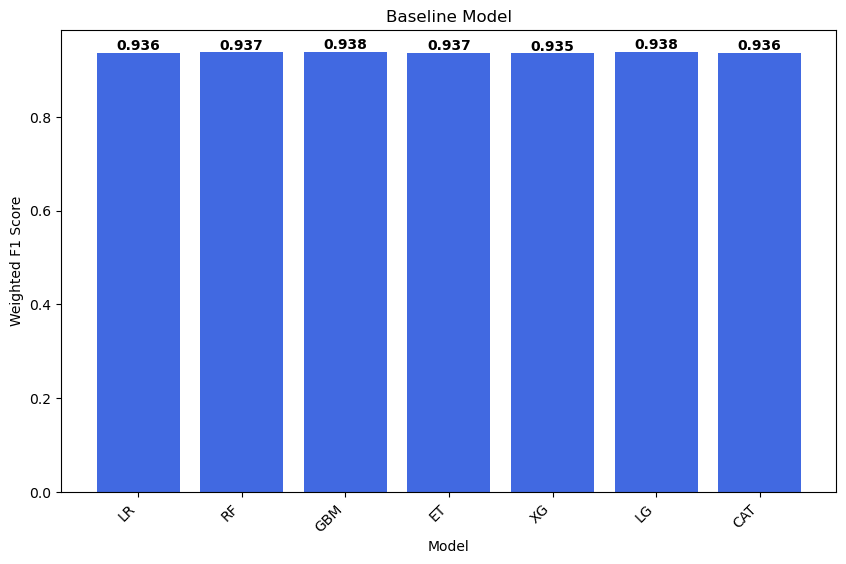

In [112]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(result.Model, result["F1 Score Weighted"], color='royalblue')
plt.xlabel('Model')
plt.ylabel('Weighted F1 Score')
plt.title('Baseline Model')
plt.xticks(rotation=45, ha="right")

# Display the values on top of the bars
for i, v in enumerate(result["F1 Score Weighted"]):
    plt.text(i, v, f"{v:.3f}", ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.savefig('baselinemodel.png')

In [26]:
import optuna

In [27]:
def rm(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))    
    for col in df.columns:
        col_type = df[col].dtype        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [28]:
data.weight = data.weight.fillna(85.84)

In [29]:
optimized_data = rm(df = data)

Memory usage of dataframe is 29.79 MB
Memory usage after optimization is: 5.25 MB
Decreased by 82.4%


In [30]:
target_data = optimized_data.readmitted
train_data = optimized_data.drop("readmitted", axis = "columns")

In [31]:
def objective(trial , X = train_data, y = target_data):
    train_x , test_x , train_y , test_y = train_test_split(X , y , test_size = 0.2 , random_state = 42, stratify = y)    
    params = {
        'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
        'C' : trial.suggest_loguniform("C", 1e-2, 1),
       'fit_intercept' : trial.suggest_categorical('fit_intercept' , [True, False]),
       'solver' : trial.suggest_categorical('solver' , ['lbfgs','liblinear']),
        "n_jobs" : -1
    }
    model1 = LogisticRegression(**params, random_state = 2020)
    model1.fit(train_x , train_y)
    y_predlr = model1.predict(test_x)
    ll = f1_score(test_y , y_predlr, average="weighted")
    return ll

In [32]:
target_data = optimized_data.readmitted
train_data = optimized_data.drop("readmitted", axis = "columns")

In [91]:
optuna.logging.set_verbosity(optuna.logging.WARNING) # i do not want to see trail information
study = optuna.create_study(direction = 'minimize' , study_name = 'lr', pruner = optuna.pruners.HyperbandPruner())
study.optimize(objective, n_trials = 50)
print('numbers of the finished trials:' , len(study.trials))
print('the best params:' , study.best_trial.params)
print('the best value:' , study.best_value)

C:\Users\user\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(
C:\Users\user\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(
C:\Users\user\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(
C:\Users\user\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(
C:\Users\user\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got '

numbers of the finished trials: 50
the best params: {'tol': 0.0005960775312811008, 'C': 0.1435333247663179, 'fit_intercept': True, 'solver': 'liblinear'}
the best value: 0.8352285603235171


- Logistic Regression Result

numbers of the finished trials: 50

the best params: {'tol': 1.080820167727918e-05, 'C': 0.041231805507969725, 'fit_intercept': False, 'solver': 'liblinear'}

the best value: 0.8352285603235171

In [81]:
data.weight.min()

12.0

In [92]:
def objective_rfc(trial, X=train_data, y=target_data):
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    params = {
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_float('min_samples_split', 0.01, 0.5),
        'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.01, 0.5),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'n_jobs': -1,
        'random_state': 2020
    }
    
    model = RandomForestClassifier(**params, n_estimators = 1500)
    model.fit(train_x, train_y)
    y_pred_rf = model.predict(test_x)
    f1_weighted = f1_score(test_y, y_pred_rf, average='weighted')
    return f1_weighted

In [93]:
optuna.logging.set_verbosity(optuna.logging.WARNING) # i do not want to see trail information
study_rfc = optuna.create_study(direction = 'minimize' , study_name = 'rfc', pruner = optuna.pruners.HyperbandPruner())
study_rfc.optimize(objective_rfc, n_trials = 50)
print('numbers of the finished trials:' , len(study_rfc.trials))
print('the best params:' , study_rfc.best_trial.params)
print('the best value:' , study_rfc.best_value)

numbers of the finished trials: 50
the best params: {'max_depth': 11, 'min_samples_split': 0.08061737763501853, 'min_samples_leaf': 0.4317715692288943, 'max_features': 'sqrt'}
the best value: 0.8332799914115974


In [95]:
    
def objective_gbt(trial, X=train_data, y=target_data):
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_float('min_samples_split', 0.01, 0.5),
        'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.01, 0.5),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'random_state': 2020
    }
    
    model = GradientBoostingClassifier(**params, n_estimators=1500)
    model.fit(train_x, train_y)
    y_pred_rf = model.predict(test_x)
    f1_weighted = f1_score(test_y, y_pred_rf, average='weighted')
    return f1_weighted

In [96]:
optuna.logging.set_verbosity(optuna.logging.WARNING) # i do not want to see trail information
study_gbt = optuna.create_study(direction = 'minimize' , study_name = 'rfc', pruner = optuna.pruners.HyperbandPruner())
study_gbt.optimize(objective_gbt, n_trials = 50)
print('numbers of the finished trials:' , len(study_gbt.trials))
print('the best params:' , study_gbt.best_trial.params)
print('the best value:' , study_gbt.best_value)

numbers of the finished trials: 50
the best params: {'learning_rate': 0.03382028862677756, 'max_depth': 6, 'min_samples_split': 0.22647895404937093, 'min_samples_leaf': 0.02614225027460998, 'max_features': 'sqrt', 'subsample': 0.7900090154646487}
the best value: 0.8332053423959036


In [97]:
def objective_gb(trial, X=train_data, y=target_data):
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 10),
    'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'n_jobs': -1,
        'random_state': 2020
    }
    
    model = XGBClassifier(**params)
    model.fit(train_x, train_y)
    y_pred_xgb = model.predict(test_x)
    f1_weighted = f1_score(test_y, y_pred_xgb, average='weighted')
    return f1_weighted

In [98]:
optuna.logging.set_verbosity(optuna.logging.WARNING) # i do not want to see trail information
study_gb = optuna.create_study(direction = 'minimize' , study_name = 'rfc', pruner = optuna.pruners.HyperbandPruner())
study_gb.optimize(objective_gb, n_trials = 50)
print('numbers of the finished trials:' , len(study_gbt.trials))
print('the best params:' , study_gb.best_trial.params)
print('the best value:' , study_gb.best_value)

numbers of the finished trials: 50
the best params: {'learning_rate': 0.05485777506438099, 'max_depth': 3, 'min_child_weight': 9.99024896255534, 'gamma': 0.012971846771630838}
the best value: 0.8335453728091722


In [99]:
def objective_lgb(trial, X=train_data, y=target_data):
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'num_leaves': trial.suggest_int('num_leaves', 31, 1023),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 20),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 1, 5),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-9, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-9, 10.0),
        'n_jobs': -1,
        'random_state': 2020
    }
    
    model = LGBMClassifier(**params, n_estimators=1500)
    model.fit(train_x, train_y)
    y_pred_lgbm = model.predict(test_x)
    f1_weighted = f1_score(test_y, y_pred_lgbm, average='weighted')
    return f1_weighted

In [100]:
optuna.logging.set_verbosity(optuna.logging.WARNING) # i do not want to see trail information
study_lgb = optuna.create_study(direction = 'minimize' , study_name = 'lgb', pruner = optuna.pruners.HyperbandPruner())
study_lgb.optimize(objective_lgb, n_trials = 50)
print('numbers of the finished trials:' , len(study_lgb.trials))
print('the best params:' , study_lgb.best_trial.params)
print('the best value:' , study_lgb.best_value)

numbers of the finished trials: 50
the best params: {'learning_rate': 0.010086960882768474, 'max_depth': 3, 'num_leaves': 451, 'min_child_samples': 19, 'subsample': 0.9050537971807502, 'colsample_bytree': 0.9832730500853207, 'subsample_freq': 2, 'reg_alpha': 2.114000183874016e-06, 'reg_lambda': 0.019156374967296726}
the best value: 0.8343813620618454


In [33]:
def objective_cat(trial, X=train_data, y=target_data):
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 20),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.6, 1.0),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10.0),
        'random_state': 2020,
        'silent': True 
    }
    
    model = CatBoostClassifier(**params, n_estimators = 1500)
    model.fit(train_x, train_y)
    y_pred_catboost = model.predict(test_x)
    f1_weighted = f1_score(test_y, y_pred_catboost, average='weighted')
    return f1_weighted

In [34]:
def print_trials(study, trial):
    print(f"Trial {trial.number} - Value: {trial.value:.6f}")
    if trial.state == optuna.trial.TrialState.FAIL:
        print(f"Trial {trial.number} failed.")

In [35]:
optuna.logging.set_verbosity(optuna.logging.WARNING)  # Set the verbosity to a minimum level
study_cat = optuna.create_study(direction='minimize',study_name='cat',pruner=optuna.pruners.HyperbandPruner())
study_cat.optimize(objective_cat, n_trials=50, callbacks=[print_trials])

print('Numbers of the finished trials:', len(study_cat.trials))
print('The best params:', study_cat.best_trial.params)
print('The best value:', study_cat.best_value)

Trial 0 - Value: 0.836469
Trial 1 - Value: 0.835875
Trial 2 - Value: 0.836796
Trial 3 - Value: 0.836009
Trial 4 - Value: 0.835864
Trial 5 - Value: 0.834931
Trial 6 - Value: 0.835757
Trial 7 - Value: 0.836637
Trial 8 - Value: 0.835705
Trial 9 - Value: 0.836928
Trial 10 - Value: 0.835435
Trial 11 - Value: 0.834973
Trial 12 - Value: 0.835435
Trial 13 - Value: 0.836087
Trial 14 - Value: 0.835016
Trial 15 - Value: 0.836284
Trial 16 - Value: 0.836298
Trial 17 - Value: 0.835544
Trial 18 - Value: 0.835958
Trial 19 - Value: 0.835229
Trial 20 - Value: 0.835812
Trial 21 - Value: 0.835674
Trial 22 - Value: 0.835648
Trial 23 - Value: 0.836495
Trial 25 - Value: 0.836020
Trial 26 - Value: 0.835358
Trial 27 - Value: 0.836298
Trial 28 - Value: 0.835760


Training has stopped (degenerate solution on iteration 1136, probably too small l2-regularization, try to increase it)


Trial 30 - Value: 0.836088
Trial 31 - Value: 0.835617
Trial 32 - Value: 0.835787
Trial 33 - Value: 0.835879
Trial 34 - Value: 0.835918
Trial 35 - Value: 0.835849
Trial 36 - Value: 0.836560
Trial 37 - Value: 0.835849


Training has stopped (degenerate solution on iteration 678, probably too small l2-regularization, try to increase it)


Trial 38 - Value: 0.836600
Trial 39 - Value: 0.835864
Trial 40 - Value: 0.834777
Trial 41 - Value: 0.835409
Trial 42 - Value: 0.834760
Trial 43 - Value: 0.835093
Trial 44 - Value: 0.835994
Trial 45 - Value: 0.836298
Trial 46 - Value: 0.835212
Trial 47 - Value: 0.837228
Trial 48 - Value: 0.836046
Trial 49 - Value: 0.835076
Numbers of the finished trials: 50
The best params: {'max_depth': 10, 'min_child_samples': 9, 'colsample_bylevel': 0.6427255573185624, 'subsample': 0.7813719342485228, 'l2_leaf_reg': 7.2621009570354215e-06}
The best value: 0.8342902290969217


In [29]:
def objective_EXT(trial, X=train_data, y=target_data):
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    params = {
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_float('min_samples_split', 0.01, 0.5),
        'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.01, 0.5),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'n_jobs': -1,
        'random_state': 2020
    }
    
    model = ExtraTreesClassifier(**params, n_estimators = 1500)
    model.fit(train_x, train_y)
    y_pred_et = model.predict(test_x)
    f1_weighted = f1_score(test_y, y_pred_et, average='weighted')
    return f1_weighted

In [32]:
optuna.logging.set_verbosity(optuna.logging.WARNING) # i do not want to see trail information
study_ext = optuna.create_study(direction = 'minimize' , study_name = 'ext', pruner = optuna.pruners.HyperbandPruner())
study_ext.optimize(objective_EXT, n_trials = 50)
print('numbers of the finished trials:' , len(study_ext.trials))
print('the best params:' , study_ext.best_trial.params)
print('the best value:' , study_ext.best_value)

numbers of the finished trials: 50
the best params: {'max_depth': 26, 'min_samples_split': 0.021711052309274226, 'min_samples_leaf': 0.472092158052296, 'max_features': 'sqrt'}
the best value: 0.8332799914115974


## OPTIMISED RESULT

In [45]:
log_param = {'tol': 0.0005960775312811008, 'C': 0.1435333247663179, 'fit_intercept': True,'solver': 'liblinear'}
rfc_param = {'max_depth': 11, 'min_samples_split': 0.08061737763501853,'min_samples_leaf': 0.4317715692288943, 'max_features': 'sqrt'}
gbt_param = {'learning_rate': 0.03382028862677756, 'max_depth': 6, 'min_samples_split': 0.22647895404937093, 'min_samples_leaf': 0.02614225027460998, 'max_features': 'sqrt', 'subsample': 0.7900090154646487}
ext_param = {'max_depth': 26, 'min_samples_split': 0.021711052309274226, 'min_samples_leaf': 0.472092158052296, 'max_features': 'sqrt'}
xg_param = {'learning_rate': 0.05485777506438099, 'max_depth': 3, 'min_child_weight': 9.99024896255534, 'gamma': 0.012971846771630838}
lg_param = {'learning_rate': 0.010086960882768474, 'max_depth': 3, 'num_leave': 451, 'min_child_samples': 19, 'subsample': 0.9050537971807502, 'colsample_bytree': 0.9832730500853207, 'subsample_freq': 2, 'reg_alpha': 2.1140e-06, 'reg_lambda': 0.019156374967296726}
cat_param = {'max_depth': 10, 'min_child_samples': 9, 'colsample_bylevel': 0.6427255573185624, 'subsample': 0.7813719342485228, 'l2_leaf_reg': 7.2621009570354215e-06}

In [46]:
def OptimizedModel():
    optimizedModels = []
    optimizedModels.append(('LR'   , LogisticRegression(**log_param)))
    optimizedModels.append(('RF'   , RandomForestClassifier(**rfc_param, n_estimators = 1500)))
    optimizedModels.append(('GBM'  , GradientBoostingClassifier(**gbt_param, n_estimators = 1500)))
    optimizedModels.append(('ET'   , ExtraTreesClassifier(**ext_param, n_estimators = 1500)))
    optimizedModels.append(('XG'   , XGBClassifier(**xg_param, n_estimators = 1500)))
    optimizedModels.append(('LG'   , LGBMClassifier(**lg_param, n_estimators = 1500)))
    optimizedModels.append(('CAT'   , CatBoostClassifier(**cat_param, n_estimators = 1500, silent=True)))
    return optimizedModels

In [47]:
optimized_model = OptimizedModel()

In [48]:
#result 
optimized_result = BasedLine(df = data, method = weight_mean, models = optimized_model, n_splits=10)

Running LG:   0%|                                                                               | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Unknown parameter: num_leave


Running LG:  10%|███████                                                                | 1/10 [00:14<02:09, 14.39s/it]

[LightGBM] [Warning] Unknown parameter: num_leave


Running LG:  20%|██████████████▏                                                        | 2/10 [00:28<01:54, 14.36s/it]

[LightGBM] [Warning] Unknown parameter: num_leave


Running LG:  30%|█████████████████████▎                                                 | 3/10 [00:43<01:42, 14.71s/it]

[LightGBM] [Warning] Unknown parameter: num_leave


Running LG:  40%|████████████████████████████▍                                          | 4/10 [01:05<01:43, 17.27s/it]

[LightGBM] [Warning] Unknown parameter: num_leave


Running LG:  50%|███████████████████████████████████▌                                   | 5/10 [01:18<01:18, 15.80s/it]

[LightGBM] [Warning] Unknown parameter: num_leave


Running LG:  60%|██████████████████████████████████████████▌                            | 6/10 [01:33<01:01, 15.46s/it]

[LightGBM] [Warning] Unknown parameter: num_leave


Running LG:  70%|█████████████████████████████████████████████████▋                     | 7/10 [01:46<00:44, 14.75s/it]

[LightGBM] [Warning] Unknown parameter: num_leave


Running LG:  80%|████████████████████████████████████████████████████████▊              | 8/10 [01:58<00:28, 14.04s/it]

[LightGBM] [Warning] Unknown parameter: num_leave


Running LG:  90%|███████████████████████████████████████████████████████████████▉       | 9/10 [02:23<00:17, 17.35s/it]

[LightGBM] [Warning] Unknown parameter: num_leave


Running CAT: 100%|████████████████████████████████████████████████████████████████████| 10/10 [39:22<00:00, 236.21s/it]

| Model   |    F1 Score |   F1 Score Weighted |
|---------+-------------+---------------------|
| LR      | 0.0220447   |            0.93759  |
| RF      | 0           |            0.939869 |
| GBM     | 0.000879353 |            0.939712 |
| ET      | 0           |            0.939869 |
| XG      | 0.0214954   |            0.937261 |
| LG      | 0.0150896   |            0.938431 |
| CAT     | 0.0195913   |            0.937081 |
Execution time: 7441.22 seconds


In [49]:
optimized_result

,Model,F1 Score,F1 Score Weighted
0,LR,0.022045,0.937590
1,RF,0.000000,0.939869
2,GBM,0.000879,0.939712
3,ET,0.000000,0.939869
4,XG,0.021495,0.937261
5,LG,0.015090,0.938431
6,CAT,0.019591,0.937081


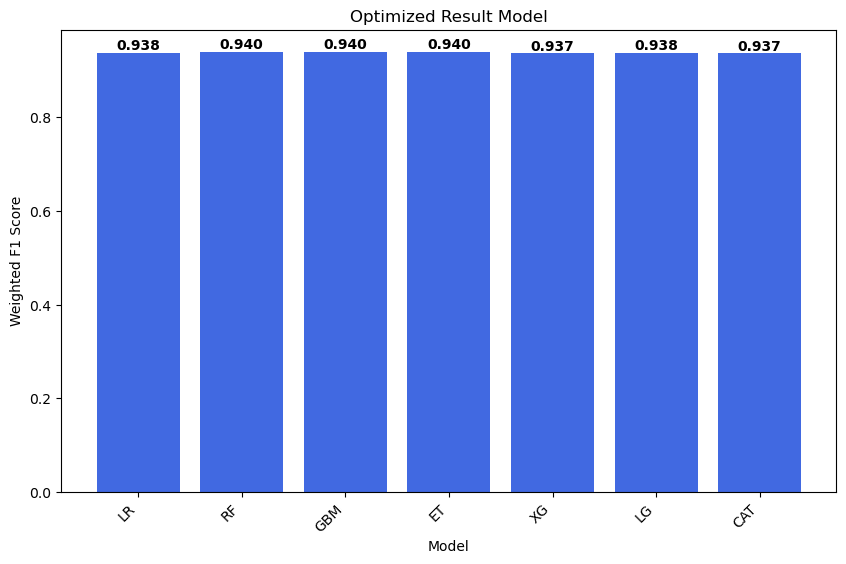

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(optimized_result.Model, optimized_result["F1 Score Weighted"], color='royalblue')
plt.xlabel('Model')
plt.ylabel('Weighted F1 Score')
plt.title('Optimized Result Model')
plt.xticks(rotation=45, ha="right")

# Display the values on top of the bars
for i, v in enumerate(optimized_result["F1 Score Weighted"]):
    plt.text(i, v, f"{v:.3f}", ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.savefig('optimized_result_bar.png')

## SHAP ANALYSIS

In [56]:
train_x, test_x, train_y, test_y = train_test_split(train_data, target_data, test_size=0.2, random_state=42, stratify=target_data)

In [94]:
# Prepares a default instance of the random forest regressor
#model = RandomForestClassifier(**rfc_param, n_estimators=1500)
model = LGBMClassifier(**lg_param, n_estimators=1500)
model2 = LogisticRegression(**log_param)
model3 = XGBClassifier(**xg_param, n_estimator=1500)


# Fits the model on the data
model.fit(train_x, train_y)

[LightGBM] [Warning] Unknown parameter: num_leave


LGBMClassifier(colsample_bytree=0.9832730500853207,
               learning_rate=0.010086960882768474, max_depth=3,
               min_child_samples=19, n_estimators=1500, num_leave=451,
               reg_alpha=2.114e-06, reg_lambda=0.019156374967296726,
               subsample=0.9050537971807502, subsample_freq=2)

In [59]:
import shap

In [80]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test_x)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


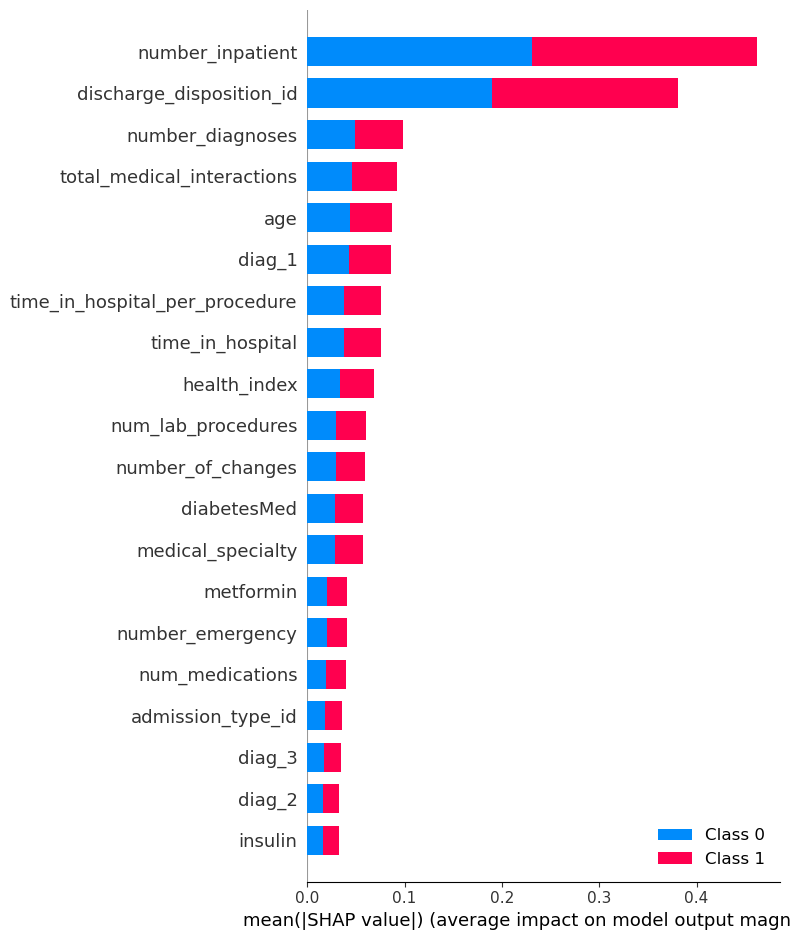

<Figure size 640x480 with 0 Axes>

In [69]:
shap.summary_plot(shap_values, test_x)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


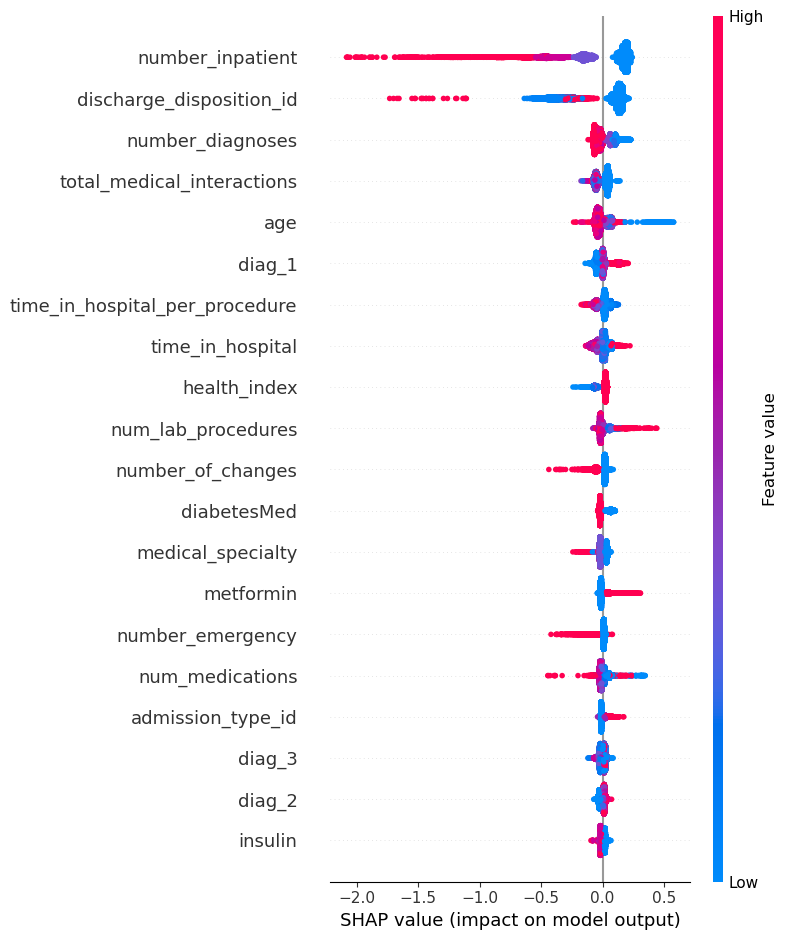

In [90]:
shap.summary_plot(shap_values[0], test_x)

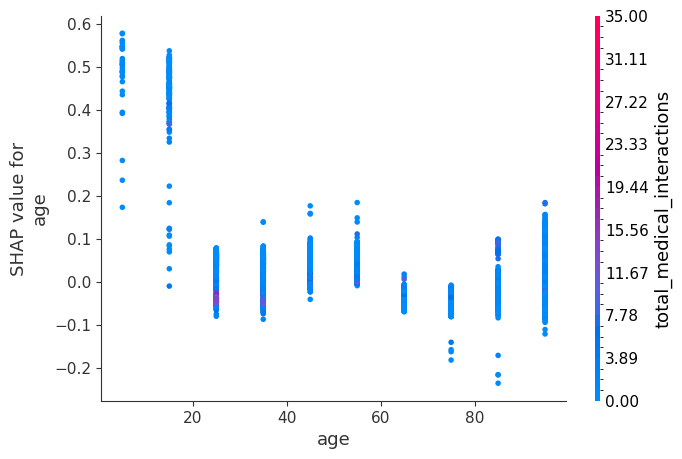

In [93]:
shap.dependence_plot("age", shap_values[0], test_x,interaction_index="total_medical_interactions")

In [95]:
model3.fit(train_x, train_y)
explainer = shap.TreeExplainer(model3)
shap_values = explainer.shap_values(test_x)

[03:58:31] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "n_estimator" } are not used.



No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


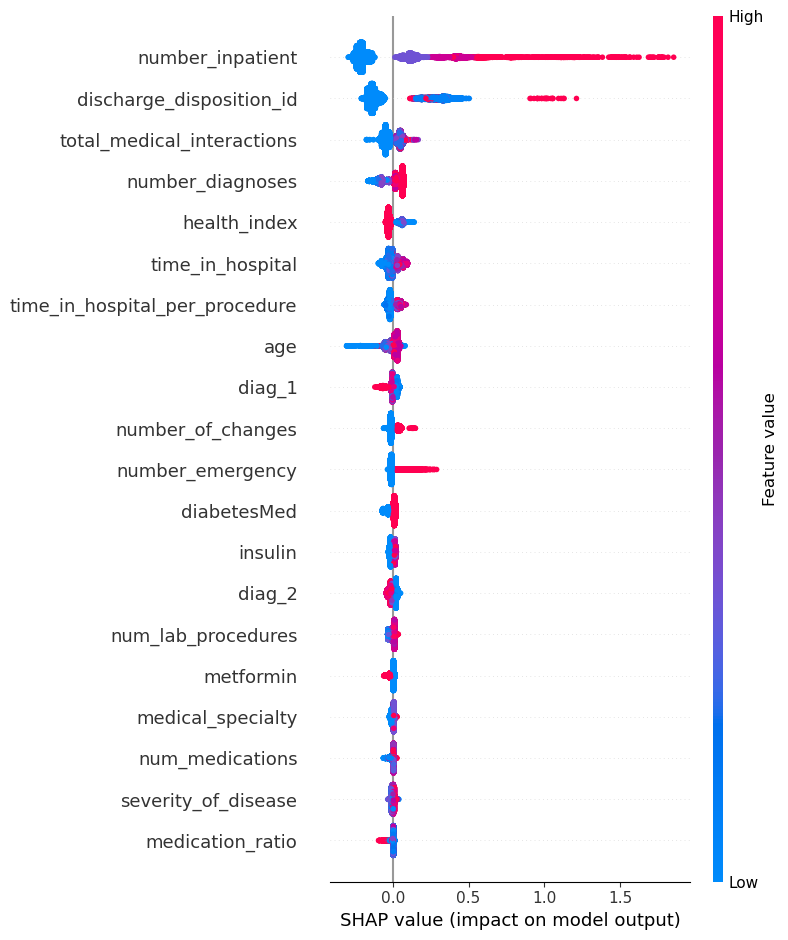

In [96]:
shap.summary_plot(shap_values, test_x)

In [100]:
model2.fit(train_x, train_y)
explainer = shap.Explainer(model2, test_x)
shap_values = explainer.shap_values(test_x)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


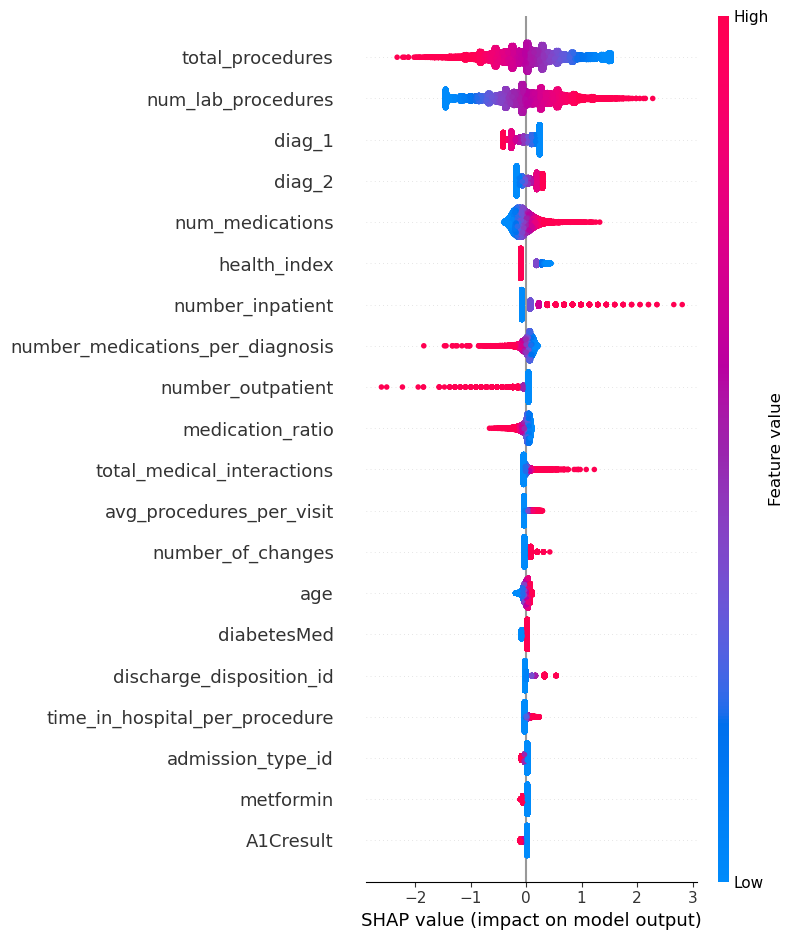

In [103]:
shap.summary_plot(shap_values, test_x)